# Creating a model to predict players' positions

In [2]:
%matplotlib inline
import json
import pickle
import numpy as np
import pandas as pd
from typing import List, Tuple
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import urllib.request
plt.rcParams['figure.figsize'] = [18, 9]
np.random.seed(1)

In [3]:
fm_dataset = pd.read_csv("https://raw.githubusercontent.com/diogodanielsoaresferreira/football_machine_learning/master/dataset.csv")

## Data Visualization

In [4]:
fm_dataset.head()

,UID,Name,NationID,Born,Age,IntCaps,IntGoals,U21Caps,U21Goals,Height,...,AttackingMidRight,DefenderCentral,DefenderLeft,DefenderRight,DefensiveMidfielder,MidfielderCentral,MidfielderLeft,MidfielderRight,WingBackLeft,WingBackRight
0,1000055,Wilfred Bamnjo,11,27-03-1980,36,0,0,0,0,178,...,1,1,1,1,20,11,1,1,1,1
1,1000331,Wang Wei,110,20-02-1982,34,0,0,0,0,188,...,1,1,1,1,1,1,1,1,1,1
2,1000334,Liu Yang,110,11-04-1982,34,0,0,0,0,183,...,1,1,1,1,20,1,1,1,1,1
3,1000337,Song Qi,110,07-04-1985,31,0,0,0,0,170,...,1,1,1,1,1,1,1,1,1,1
4,1000340,Chen Lei,110,20-01-1983,33,0,0,0,0,181,...,1,1,1,1,1,1,1,1,1,1


In [5]:
print(fm_dataset.columns)

Index(['UID', 'Name', 'NationID', 'Born', 'Age', 'IntCaps', 'IntGoals',
       'U21Caps', 'U21Goals', 'Height', 'Weight', 'AerialAbility',
       'CommandOfArea', 'Communication', 'Eccentricity', 'Handling', 'Kicking',
       'OneOnOnes', 'Reflexes', 'RushingOut', 'TendencyToPunch', 'Throwing',
       'Corners', 'Crossing', 'Dribbling', 'Finishing', 'FirstTouch',
       'Freekicks', 'Heading', 'LongShots', 'Longthrows', 'Marking', 'Passing',
       'PenaltyTaking', 'Tackling', 'Technique', 'Aggression', 'Anticipation',
       'Bravery', 'Composure', 'Concentration', 'Vision', 'Decisions',
       'Determination', 'Flair', 'Leadership', 'OffTheBall', 'Positioning',
       'Teamwork', 'Workrate', 'Acceleration', 'Agility', 'Balance', 'Jumping',
       'LeftFoot', 'NaturalFitness', 'Pace', 'RightFoot', 'Stamina',
       'Strength', 'Consistency', 'Dirtiness', 'ImportantMatches',
       'InjuryProness', 'Versatility', 'Adaptability', 'Ambition', 'Loyalty',
       'Pressure', 'Professional',

In [5]:
# Almost 160k players
print(len(fm_dataset.Name))

159541


In [6]:
# 213 nations
print(len(np.unique(fm_dataset.NationID)))
print(np.unique(fm_dataset.NationID))

213
[       5        6        7        8        9       10       11       12
       13       14       15       16       17       18       19       20
       21       22       23       24       25       26       27       28
       29       30       31       32       33       34       35       36
       37       38       39       40       41       43       44       45
       46       47       48       49       50       51       52       53
       54       55      106      107      108      109      110      111
      112      113      114      115      116      117      118      119
      120      121      122      123      124      125      126      127
      128      129      130      131      132      133      134      135
      136      137      138      139      140      141      142      143
      144      145      146      359      360      361      362      363
      364      365      366      367      370      371      373      374
      375      376      377      379      380  

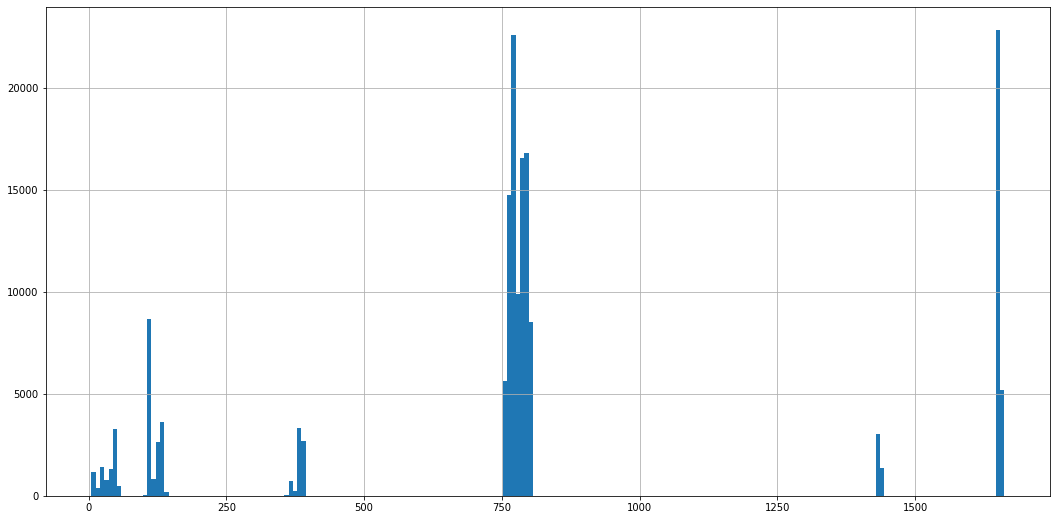

In [7]:
# Distribution of players per country
fm_dataset.NationID[fm_dataset.NationID<100000].hist(bins=len(np.unique(fm_dataset.NationID)))

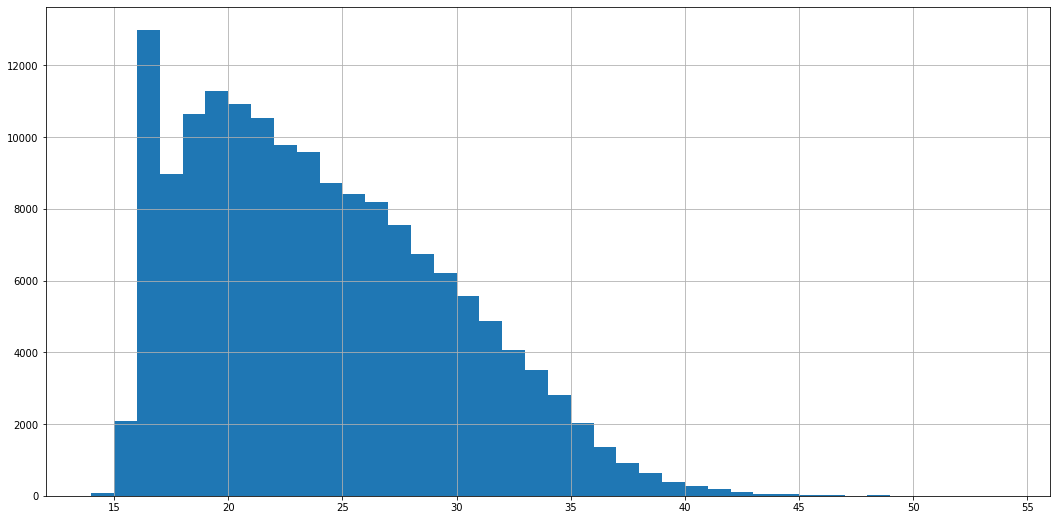

In [8]:
# Distribution of players by age
fm_dataset.Age.hist(bins=len(np.unique(fm_dataset.Age)))

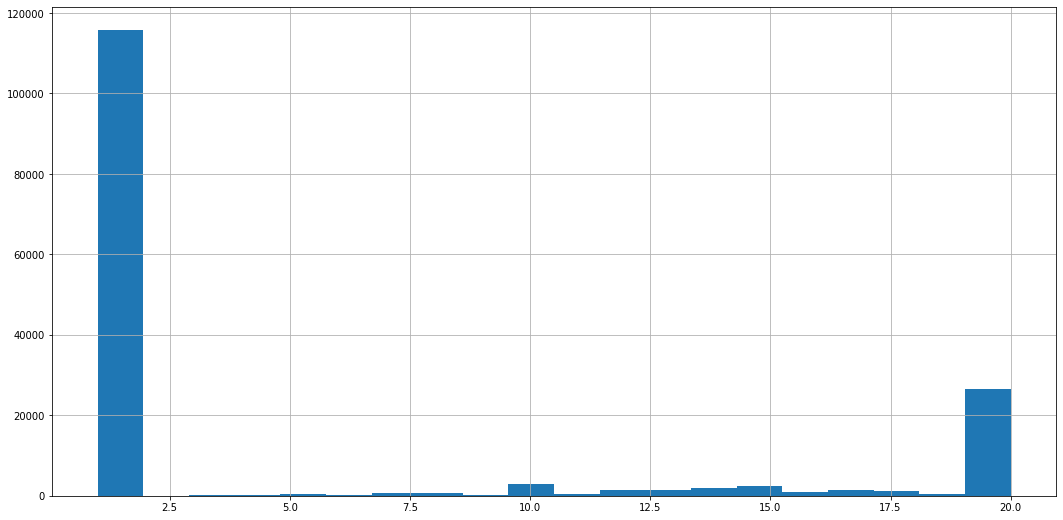

In [9]:
# Distribution of values suited for a striker
fm_dataset.Striker.hist(bins=20)

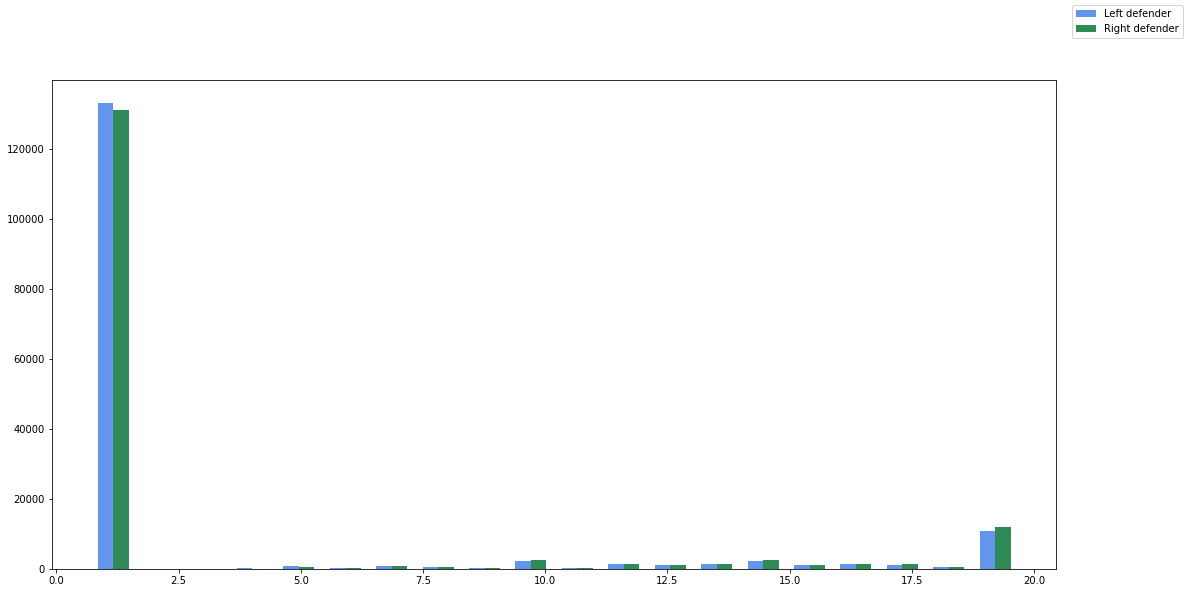

In [10]:
# Distribution of values suited for a left and right defender
# There are more right than left defenders
fig, ax = plt.subplots()
bins = 20

a_heights, a_bins = np.histogram(fm_dataset.DefenderLeft, bins=20)
b_heights, b_bins = np.histogram(fm_dataset.DefenderRight, bins=20)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue', label="Left defender")
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen', label="Right defender")
fig.legend()

## Feature Selection

In [4]:
features = ['Age', 'Height', 'Weight', 'AerialAbility', 'CommandOfArea',
            'Communication', 'Eccentricity', 'Handling', 'Kicking',
            'OneOnOnes', 'Reflexes', 'RushingOut', 'TendencyToPunch', 'Throwing',
            'Corners', 'Crossing', 'Dribbling', 'Finishing', 'FirstTouch',
            'Freekicks', 'Heading', 'LongShots', 'Longthrows', 'Marking', 'Passing',
            'PenaltyTaking', 'Tackling', 'Technique', 'Aggression', 'Anticipation',
            'Bravery', 'Composure', 'Concentration', 'Vision', 'Decisions',
            'Determination', 'Flair', 'OffTheBall', 'Positioning',
            'Teamwork', 'Workrate', 'Acceleration', 'Agility', 'Balance', 'Jumping',
            'LeftFoot', 'NaturalFitness', 'Pace', 'RightFoot', 'Stamina',
            'Strength']

classification_labels = ['Goalkeeper', 'Sweeper', 'Striker',
                         'AttackingMidCentral', 'AttackingMidLeft', 'AttackingMidRight',
                         'DefenderCentral', 'DefenderLeft', 'DefenderRight',
                         'DefensiveMidfielder', 'MidfielderCentral', 'MidfielderLeft',
                         'MidfielderRight', 'WingBackLeft', 'WingBackRight']


features = fm_dataset[features]
classification = fm_dataset[classification_labels]

The problem will be formulated as a multi-label classification problem, where it is possible for a player to be labeled with more than one position.

In [5]:
# Player can play in a position if its skill is >=15
classification[classification<15] = 0
classification[classification>=15] = 1

<ipython-input-5-c117563abad0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification[classification<15] = 0
/home/diogoferreira/.local/lib/python3.8/site-packages/pandas/core/frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
<ipython-input-5-c117563abad0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

## Test different approaches with 5-fold cross-validation

In [91]:
def evaluate_predictions(labels: List[str], actual_values: np.ndarray, predictions: np.ndarray) -> Tuple[dict, float]:
    """Evaluate the predictions of the model.
    
    Returns a dictionary with the recall, precision and F1-score for each label
    and the overall average F1-score.
    """
    f1_scores = []
    results = {}
    for label, actual, pred in zip(labels, actual_values, predictions):
        results[label] = {"recall": recall_score(actual, pred),
                          "precision": precision_score(actual, pred),
                          "f1-score": f1_score(actual, pred)}
        f1_scores.append(f1_score(actual, pred))
    return results, sum(f1_scores)/len(f1_scores)

First, we will calculate 5-fold cross-validation with K-Nearest Neighbors and with a Random Forest. You can tweak the hyper-parameters to try to improve the accuracy. We will also store the predictions for every player.

If you are training with all the data, it can take a while.

In [142]:
scaler = StandardScaler()
kf = KFold(5)

#classifier = KNeighborsClassifier()
classifier = RandomForestClassifier()

all_train_y = None
all_test_y = None
all_train_predictions = None
all_test_predictions = None

for train_index, test_index in kf.split(features):
    
    train_X, train_y = features.loc[train_index], classification.loc[train_index]
    test_X, test_y = features.loc[test_index], classification.loc[test_index]
    
    train_X_scaled = scaler.fit_transform(train_X)
    classifier.fit(train_X, train_y)
    
    train_predictions = classifier.predict(train_X)
    test_predictions = classifier.predict(test_X)
    
    if all_test_y is None:
        all_train_y = train_y.values.T
        all_test_y = test_y.values.T
        all_train_predictions = train_predictions.T
        all_test_predictions = test_predictions.T
    else:
        all_train_y = np.hstack((all_train_y, train_y.values.T))
        all_test_y = np.hstack((all_test_y, test_y.values.T))
        all_train_predictions = np.hstack((all_train_predictions, train_predictions.T))
        all_test_predictions = np.hstack((all_test_predictions, test_predictions.T))

Store the predictions and the metrics in a file.

Mean test F1-score for KNN: 59.63%.

Mean test F1-score for RF: 59.38%.

The results seem similar for both approaches, but Random Forest train time is faster.

In [144]:
train_results, train_mean_f1_score = evaluate_predictions(classification_labels, all_train_y, all_train_predictions)
test_results, test_mean_f1_score = evaluate_predictions(classification_labels, all_test_y, all_test_predictions)
print(f'Mean train F1-score: {train_mean_f1_score}')
print(f'Mean test F1-score: {test_mean_f1_score}')

with open("resultsRF.json", "w+") as f:
    json.dump(test_results, f, indent=4)

np.savetxt('predictionsRF.txt', all_test_predictions, fmt='%d')

Mean train F1-score: 0.9999136592030651
Mean test F1-score: 0.585368342709637


Now let's try to train a Neural Network, using PyTorch! It will be a simple neural network with just one layer. You can try to improve the results by tweaking the Neural Network parameters.

In [9]:
class Net(nn.Module):
    
    def __init__(self, n_features: int, output_classes: int):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, output_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

In [32]:
def train_model(network, train_x_scaled, train_y, test_x_scaled, test_y, n_epochs, batch_size, optimizer, criterion, labels):
    
    train_x_tensor = torch.tensor(train_X_scaled).to(device).float()
    train_y_tensor = torch.tensor(train_y.values).to(device).float()
    test_x_tensor = torch.tensor(test_X_scaled).to(device).float()
    
    train_f1_score = []
    test_f1_score = []
    
    for epoch in range(n_epochs):
        for i in range(0,train_x_tensor.size()[0], batch_size):
            optimizer.zero_grad()
            
            batch_x, batch_y = train_x_tensor[i:i+batch_size], train_y_tensor[i:i+batch_size]
            
            outputs = network(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():
            train_predictions = net(train_x_tensor)
            train_predictions = train_predictions.to("cpu").numpy()>0
            test_predictions = net(test_x_tensor)
            test_predictions = test_predictions.to("cpu").numpy()>0
        
        print(f'End of epoch {epoch+1}')
        print(f'Loss: {loss}')
        
        _, train_mean_f1_score = evaluate_predictions(labels, train_y.values, train_predictions)
        print(f'Mean train F1-score: {train_mean_f1_score}')
        
        _, test_mean_f1_score = evaluate_predictions(labels, test_y.values, test_predictions)
        print(f'Mean test F1-score: {test_mean_f1_score}')
        print()
        
        train_f1_score.append(train_mean_f1_score)
        test_f1_score.append(test_mean_f1_score)
    
    return network, train_f1_score, test_f1_score

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.BCEWithLogitsLoss()

scaler = StandardScaler()
kf = KFold(5)
n_epochs = 100
batch_size = 4

all_train_y = None
all_test_y = None

all_train_predictions = None
all_test_predictions = None

train_f1_score = []
test_f1_score = []

for train_index, test_index in kf.split(features):
    
    train_X, train_y = features.loc[train_index], classification.loc[train_index]
    test_X, test_y = features.loc[test_index], classification.loc[test_index]
    
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)
    
    net = Net(features.shape[1], len(classification_labels))
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.000001)
    
    net, part_train_f1_score, part_test_f1_score = train_model(net, train_X_scaled, train_y, test_X_scaled, test_y, n_epochs, batch_size, optimizer, criterion, classification_labels)
    train_f1_score.append(part_train_f1_score)
    test_f1_score.append(part_test_f1_score)
    
    train_x_tensor = torch.tensor(train_X_scaled).to(device).float()
    train_y_tensor = torch.tensor(train_y.values).to(device).float()
    test_x_tensor = torch.tensor(test_X_scaled).to(device).float()
    
    with torch.no_grad():
        train_predictions = net(train_x_tensor)
        train_predictions = train_predictions.to("cpu").numpy()>0
        test_predictions = net(test_x_tensor)
        test_predictions = test_predictions.to("cpu").numpy()>0
    
    if all_test_y is None:
        all_train_y = train_y.values.T
        all_test_y = test_y.values.T
        all_train_predictions = train_predictions.T
        all_test_predictions = test_predictions.T
    else:
        all_train_y = np.hstack((all_train_y, train_y.values.T))
        all_test_y = np.hstack((all_test_y, test_y.values.T))
        all_train_predictions = np.hstack((all_train_predictions, train_predictions.T))
        all_test_predictions = np.hstack((all_test_predictions, test_predictions.T))

cuda:0
End of epoch 1
Loss: 0.7374862432479858
Mean train F1-score: 0.18910533910533908
Mean test F1-score: 0.1723180523180523

End of epoch 2
Loss: 0.7198596596717834
Mean train F1-score: 0.19746031746031747
Mean test F1-score: 0.202002072002072

End of epoch 3
Loss: 0.7114035487174988
Mean train F1-score: 0.2143915343915344
Mean test F1-score: 0.2260968660968661

End of epoch 4
Loss: 0.7057318091392517
Mean train F1-score: 0.2626984126984127
Mean test F1-score: 0.28051430051430054

End of epoch 5
Loss: 0.7009359002113342
Mean train F1-score: 0.2986243386243386
Mean test F1-score: 0.2933281533281533

End of epoch 6
Loss: 0.6962268352508545
Mean train F1-score: 0.32086691086691094
Mean test F1-score: 0.3196388796388796

End of epoch 7
Loss: 0.6917815208435059
Mean train F1-score: 0.3827716727716728
Mean test F1-score: 0.34285196285196284

End of epoch 8
Loss: 0.687904953956604
Mean train F1-score: 0.46985569985569975
Mean test F1-score: 0.3742472342472343

End of epoch 9
Loss: 0.684376

End of epoch 70
Loss: 0.6715289950370789
Mean train F1-score: 0.725873015873016
Mean test F1-score: 0.5325396825396825

End of epoch 71
Loss: 0.6715443134307861
Mean train F1-score: 0.725873015873016
Mean test F1-score: 0.5325396825396825

End of epoch 72
Loss: 0.6715614795684814
Mean train F1-score: 0.725873015873016
Mean test F1-score: 0.5325396825396825

End of epoch 73
Loss: 0.6715776324272156
Mean train F1-score: 0.725873015873016
Mean test F1-score: 0.5325396825396825

End of epoch 74
Loss: 0.6715894341468811
Mean train F1-score: 0.725873015873016
Mean test F1-score: 0.5325396825396825

End of epoch 75
Loss: 0.6716009974479675
Mean train F1-score: 0.725873015873016
Mean test F1-score: 0.5325396825396825

End of epoch 76
Loss: 0.6716139912605286
Mean train F1-score: 0.725873015873016
Mean test F1-score: 0.5325396825396825

End of epoch 77
Loss: 0.6716266870498657
Mean train F1-score: 0.725873015873016
Mean test F1-score: 0.5325396825396825

End of epoch 78
Loss: 0.6716408133506775

/home/diogoferreira/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


End of epoch 90
Loss: 0.6718046069145203
Mean train F1-score: 0.716984126984127
Mean test F1-score: 0.5063492063492062

End of epoch 91
Loss: 0.6718184351921082
Mean train F1-score: 0.716984126984127
Mean test F1-score: 0.5063492063492062

End of epoch 92
Loss: 0.6718343496322632
Mean train F1-score: 0.716984126984127
Mean test F1-score: 0.5063492063492062

End of epoch 93
Loss: 0.671848714351654
Mean train F1-score: 0.716984126984127
Mean test F1-score: 0.5063492063492062

End of epoch 94
Loss: 0.6718608140945435
Mean train F1-score: 0.716984126984127
Mean test F1-score: 0.5063492063492062

End of epoch 95
Loss: 0.6718709468841553
Mean train F1-score: 0.716984126984127
Mean test F1-score: 0.5063492063492062

End of epoch 96
Loss: 0.6718827486038208
Mean train F1-score: 0.716984126984127
Mean test F1-score: 0.5063492063492062

End of epoch 97
Loss: 0.6718915700912476
Mean train F1-score: 0.716984126984127
Mean test F1-score: 0.5063492063492062

End of epoch 98
Loss: 0.6718999147415161


/home/diogoferreira/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


End of epoch 13
Loss: 0.6613260507583618
Mean train F1-score: 0.27904761904761904
Mean test F1-score: 0.5634920634920636

End of epoch 14
Loss: 0.6575184464454651
Mean train F1-score: 0.2711111111111111
Mean test F1-score: 0.5968253968253968

End of epoch 15
Loss: 0.6552324295043945
Mean train F1-score: 0.2866666666666667
Mean test F1-score: 0.6

End of epoch 16
Loss: 0.6534026861190796
Mean train F1-score: 0.33111111111111113
Mean test F1-score: 0.5977777777777777

End of epoch 17
Loss: 0.651768147945404
Mean train F1-score: 0.29777777777777775
Mean test F1-score: 0.6088888888888889

End of epoch 18
Loss: 0.6503790616989136
Mean train F1-score: 0.2755555555555555
Mean test F1-score: 0.6088888888888889

End of epoch 19
Loss: 0.6490617394447327
Mean train F1-score: 0.2955555555555555
Mean test F1-score: 0.7022222222222222

End of epoch 20
Loss: 0.6479431390762329
Mean train F1-score: 0.32888888888888884
Mean test F1-score: 0.7022222222222222

End of epoch 21
Loss: 0.6469884514808655
Mea

End of epoch 81
Loss: 0.646939218044281
Mean train F1-score: 0.5622222222222223
Mean test F1-score: 0.7255555555555555

End of epoch 82
Loss: 0.646939218044281
Mean train F1-score: 0.555873015873016
Mean test F1-score: 0.7255555555555555

End of epoch 83
Loss: 0.646939218044281
Mean train F1-score: 0.555873015873016
Mean test F1-score: 0.7255555555555555

End of epoch 84
Loss: 0.6469391584396362
Mean train F1-score: 0.555873015873016
Mean test F1-score: 0.7255555555555555

End of epoch 85
Loss: 0.6469390988349915
Mean train F1-score: 0.555873015873016
Mean test F1-score: 0.7255555555555555

End of epoch 86
Loss: 0.6469390988349915
Mean train F1-score: 0.555873015873016
Mean test F1-score: 0.7255555555555555

End of epoch 87
Loss: 0.6469390988349915
Mean train F1-score: 0.555873015873016
Mean test F1-score: 0.7255555555555555

End of epoch 88
Loss: 0.6469390988349915
Mean train F1-score: 0.555873015873016
Mean test F1-score: 0.7255555555555555

End of epoch 89
Loss: 0.6469390988349915
M

/home/diogoferreira/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


End of epoch 18
Loss: 0.6469466686248779
Mean train F1-score: 0.38222222222222224
Mean test F1-score: 0.5590476190476191

End of epoch 19
Loss: 0.6469454765319824
Mean train F1-score: 0.38222222222222224
Mean test F1-score: 0.5479365079365078

End of epoch 20
Loss: 0.6469445824623108
Mean train F1-score: 0.38222222222222224
Mean test F1-score: 0.5479365079365078

End of epoch 21
Loss: 0.6469438076019287
Mean train F1-score: 0.36444444444444446
Mean test F1-score: 0.5622222222222223

End of epoch 22
Loss: 0.6469431519508362
Mean train F1-score: 0.3977777777777778
Mean test F1-score: 0.5780952380952382

End of epoch 23
Loss: 0.6469425559043884
Mean train F1-score: 0.3977777777777778
Mean test F1-score: 0.5580952380952381

End of epoch 24
Loss: 0.6469420194625854
Mean train F1-score: 0.3977777777777778
Mean test F1-score: 0.5692063492063492

End of epoch 25
Loss: 0.6469416618347168
Mean train F1-score: 0.41555555555555557
Mean test F1-score: 0.5692063492063493

End of epoch 26
Loss: 0.646

End of epoch 86
Loss: 0.6469379663467407
Mean train F1-score: 0.48666666666666664
Mean test F1-score: 0.7247619047619047

End of epoch 87
Loss: 0.6469379663467407
Mean train F1-score: 0.48666666666666664
Mean test F1-score: 0.7247619047619047

End of epoch 88
Loss: 0.6469379663467407
Mean train F1-score: 0.48666666666666664
Mean test F1-score: 0.7247619047619047

End of epoch 89
Loss: 0.6469379663467407
Mean train F1-score: 0.48666666666666664
Mean test F1-score: 0.7247619047619047

End of epoch 90
Loss: 0.6469379663467407
Mean train F1-score: 0.48666666666666664
Mean test F1-score: 0.7247619047619047

End of epoch 91
Loss: 0.6469379663467407
Mean train F1-score: 0.48666666666666664
Mean test F1-score: 0.7247619047619047

End of epoch 92
Loss: 0.6469379663467407
Mean train F1-score: 0.48666666666666664
Mean test F1-score: 0.7247619047619047

End of epoch 93
Loss: 0.6469379663467407
Mean train F1-score: 0.48666666666666664
Mean test F1-score: 0.7247619047619047

End of epoch 94
Loss: 0.

/home/diogoferreira/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


End of epoch 13
Loss: 0.6469947099685669
Mean train F1-score: 0.38936507936507936
Mean test F1-score: 0.3714285714285714

End of epoch 14
Loss: 0.6469829678535461
Mean train F1-score: 0.35603174603174603
Mean test F1-score: 0.386984126984127

End of epoch 15
Loss: 0.6469744443893433
Mean train F1-score: 0.35365079365079366
Mean test F1-score: 0.4358730158730159

End of epoch 16
Loss: 0.6469681262969971
Mean train F1-score: 0.36000000000000004
Mean test F1-score: 0.44253968253968257

End of epoch 17
Loss: 0.6469632983207703
Mean train F1-score: 0.34460317460317463
Mean test F1-score: 0.46476190476190476

End of epoch 18
Loss: 0.6469594836235046
Mean train F1-score: 0.34460317460317463
Mean test F1-score: 0.46476190476190476

End of epoch 19
Loss: 0.6469563841819763
Mean train F1-score: 0.3734920634920635
Mean test F1-score: 0.5092063492063492

End of epoch 20
Loss: 0.6469539999961853
Mean train F1-score: 0.3734920634920635
Mean test F1-score: 0.5158730158730159

End of epoch 21
Loss: 0.

End of epoch 81
Loss: 0.6469383835792542
Mean train F1-score: 0.4111111111111111
Mean test F1-score: 0.5514285714285715

End of epoch 82
Loss: 0.6469383835792542
Mean train F1-score: 0.4111111111111111
Mean test F1-score: 0.5514285714285715

End of epoch 83
Loss: 0.6469383835792542
Mean train F1-score: 0.4111111111111111
Mean test F1-score: 0.5514285714285715

End of epoch 84
Loss: 0.6469383835792542
Mean train F1-score: 0.4111111111111111
Mean test F1-score: 0.5514285714285715

End of epoch 85
Loss: 0.6469383835792542
Mean train F1-score: 0.4111111111111111
Mean test F1-score: 0.5514285714285715

End of epoch 86
Loss: 0.6469382643699646
Mean train F1-score: 0.4111111111111111
Mean test F1-score: 0.5514285714285715

End of epoch 87
Loss: 0.6469382643699646
Mean train F1-score: 0.4111111111111111
Mean test F1-score: 0.5514285714285715

End of epoch 88
Loss: 0.6469382047653198
Mean train F1-score: 0.4111111111111111
Mean test F1-score: 0.5514285714285715

End of epoch 89
Loss: 0.64693820

/home/diogoferreira/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


End of epoch 12
Loss: 0.6472773551940918
Mean train F1-score: 0.41365079365079366
Mean test F1-score: 0.7311111111111112

End of epoch 13
Loss: 0.6472181081771851
Mean train F1-score: 0.41365079365079366
Mean test F1-score: 0.7422222222222222

End of epoch 14
Loss: 0.6471732258796692
Mean train F1-score: 0.35587301587301584
Mean test F1-score: 0.7422222222222222

End of epoch 15
Loss: 0.6471384763717651
Mean train F1-score: 0.3625396825396825
Mean test F1-score: 0.7422222222222222

End of epoch 16
Loss: 0.6471108794212341
Mean train F1-score: 0.3736507936507936
Mean test F1-score: 0.7222222222222222

End of epoch 17
Loss: 0.6470885276794434
Mean train F1-score: 0.4003174603174603
Mean test F1-score: 0.7222222222222222

End of epoch 18
Loss: 0.6470704674720764
Mean train F1-score: 0.4066666666666667
Mean test F1-score: 0.7222222222222222

End of epoch 19
Loss: 0.647055447101593
Mean train F1-score: 0.4066666666666667
Mean test F1-score: 0.7222222222222222

End of epoch 20
Loss: 0.647042

End of epoch 86
Loss: 0.6469460129737854
Mean train F1-score: 0.52
Mean test F1-score: 0.8044444444444444

End of epoch 87
Loss: 0.6469458341598511
Mean train F1-score: 0.5244444444444445
Mean test F1-score: 0.8044444444444444

End of epoch 88
Loss: 0.6469457149505615
Mean train F1-score: 0.5244444444444445
Mean test F1-score: 0.8044444444444444

End of epoch 89
Loss: 0.646945595741272
Mean train F1-score: 0.5244444444444445
Mean test F1-score: 0.8044444444444444

End of epoch 90
Loss: 0.6469455361366272
Mean train F1-score: 0.5244444444444445
Mean test F1-score: 0.8044444444444444

End of epoch 91
Loss: 0.6469454765319824
Mean train F1-score: 0.5244444444444445
Mean test F1-score: 0.8044444444444444

End of epoch 92
Loss: 0.6469453573226929
Mean train F1-score: 0.5244444444444445
Mean test F1-score: 0.8044444444444444

End of epoch 93
Loss: 0.6469452381134033
Mean train F1-score: 0.5244444444444445
Mean test F1-score: 0.8266666666666667

End of epoch 94
Loss: 0.6469451189041138
Mean t

Let's plot the F1-score of the five trained models along the number of epochs.

Text(0.5, 1.0, 'Train and test f1-score')

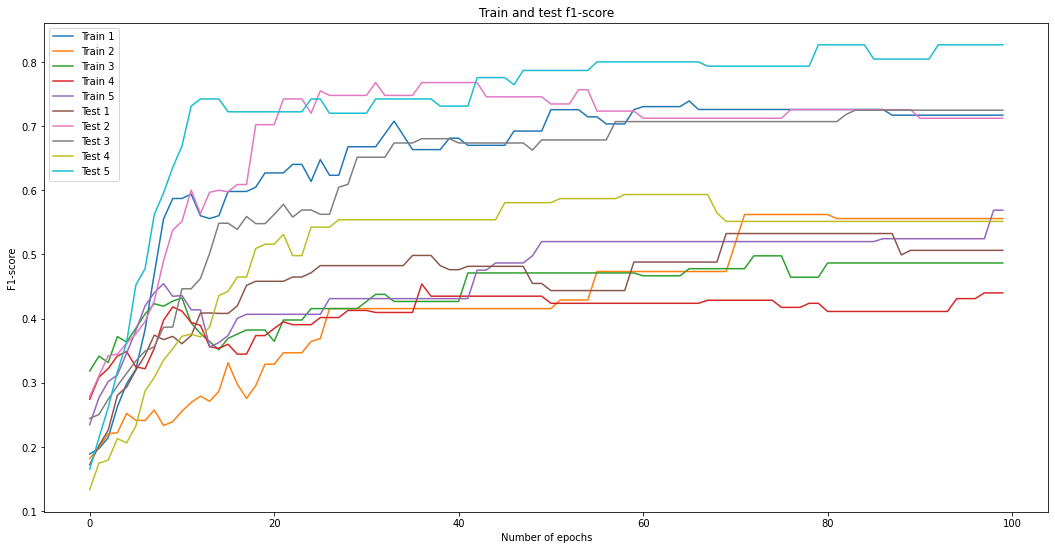

In [44]:
plt.plot(train_f1_score[0], label="Train 1")
plt.plot(train_f1_score[1], label="Train 2")
plt.plot(train_f1_score[2], label="Train 3")
plt.plot(train_f1_score[3], label="Train 4")
plt.plot(train_f1_score[4], label="Train 5")
plt.plot(test_f1_score[0], label="Test 1")
plt.plot(test_f1_score[1], label="Test 2")
plt.plot(test_f1_score[2], label="Test 3")
plt.plot(test_f1_score[3], label="Test 4")
plt.plot(test_f1_score[4], label="Test 5")
plt.legend()
plt.ylabel("F1-score")
plt.xlabel("Number of epochs")
plt.title("Train and test f1-score")

Store the predictions and the metrics in a file.

Mean test F1-score for NN: 48.60%.

In [45]:
train_results, train_mean_f1_score = evaluate_predictions(classification_labels, all_train_y, all_train_predictions)
test_results, test_mean_f1_score = evaluate_predictions(classification_labels, all_test_y, all_test_predictions)
print(f'Mean train F1-score: {train_mean_f1_score}')
print(f'Mean test F1-score: {test_mean_f1_score}')

with open("resultsFFNN.json", "w+") as f:
    json.dump(test_results, f, indent=4)

np.savetxt('predictionsFFNN.txt', all_test_predictions, fmt='%d')

Mean train F1-score: 0.48909314079407096
Mean test F1-score: 0.4860980049264985


## Train model with all data and save it

The chosen approach to train with all data is the Random Forest (it is the faster and it has a mean F1-score almost as good as the KNN).

In [105]:
scaler = StandardScaler()
classifier = RandomForestClassifier()

train_X, train_y = features.values, classification.values

train_X_scaled = scaler.fit_transform(train_X)
classifier.fit(train_X_scaled, train_y)

pickle.dump(classifier, open("RF.bin", "wb+"))
pickle.dump(scaler, open("scaler.bin", "wb+"))

## Predict the position of real players

Let's load the best predictions for all the players, and let's see which positions the algorithm predicted for each player.

This can be useful because it can give us insights about what players might actually play better in other positions, if trained to do so, based on their attributes.

In [11]:
predictions = np.loadtxt('https://raw.githubusercontent.com/diogodanielsoaresferreira/football_machine_learning/master/predictionsRF.txt', dtype=int)
print(predictions.shape)

(15, 159541)


In [12]:
def position_to_text(position, labels):
    """
    Convert a binary list of positions to text describing the position.
    """
    positions_indexes = np.where(position == 1)[0]
    predicted_position = [labels[index] for index in positions_indexes]
    return predicted_position

predicted_positions = [position_to_text(player, classification_labels) for player in predictions.T]
best_positions = [position_to_text(classif, classification_labels) for classif in classification.values]
fm_dataset['predicted_positions'] = [position_to_text(player, classification_labels) for player in predictions.T]
fm_dataset['best_positions'] = best_positions

In [120]:
players_UID = [
    735216, # Cristiano Ronaldo
    7458500, # Lionel Messi
    19024412, # Neymar
    18004457, # Kevin De Bruyne
    28049320, # Harry Kane
    653054, # Luka Modric
    8718372, # Manuel Neuer
    890613, # Philipp Lahm
    703963, # Andrea Pirlo
    5132312, # Gareth Bale
]

for player_UID in players_UID:
    player_row = fm_dataset.loc[fm_dataset['UID'] == player_UID]
    print(player_row.Name.values[0],
          player_row.best_positions.values[0],
          player_row.predicted_positions.values[0])

Cristiano Ronaldo ['Striker', 'AttackingMidLeft', 'AttackingMidRight', 'MidfielderLeft'] ['Striker', 'AttackingMidCentral']
Lionel Messi ['Striker', 'AttackingMidCentral', 'AttackingMidRight'] ['AttackingMidCentral', 'AttackingMidLeft']
Neymar ['Striker', 'AttackingMidCentral', 'AttackingMidLeft', 'MidfielderLeft'] ['AttackingMidCentral', 'AttackingMidLeft', 'AttackingMidRight']
Kevin De Bruyne ['AttackingMidCentral', 'AttackingMidLeft', 'AttackingMidRight', 'MidfielderCentral', 'MidfielderLeft', 'MidfielderRight'] ['AttackingMidCentral', 'AttackingMidLeft']
Harry Kane ['Striker'] ['Striker']
Luka Modric ['AttackingMidCentral', 'MidfielderCentral'] ['AttackingMidCentral', 'MidfielderCentral']
Manuel Neuer ['Goalkeeper'] ['Goalkeeper']
Philipp Lahm ['DefenderLeft', 'DefenderRight', 'DefensiveMidfielder', 'WingBackLeft', 'WingBackRight'] ['DefenderRight']
Andrea Pirlo ['DefensiveMidfielder', 'MidfielderCentral'] ['AttackingMidCentral', 'MidfielderCentral']
Gareth Bale ['Striker', 'Attack

In [86]:
def change_predicted_positions(value):
    """
    Update the predicted positions and change label value.
    """
    player_name = value["new"]
    player = fm_dataset.loc[fm_dataset['Name'] == player_name]
    if player.shape[0] == 0:
        label.value = "No predicted positions"
    else:
        predicted_positions = player.predicted_positions.values[0]
        label.value = ", ".join(predicted_positions)


input_player = widgets.Text(
    value='',
    placeholder='Type a player name to get its predicted positions',
    description='Player:',
    disabled=False
)
label = widgets.Label(value="")
input_player.observe(change_predicted_positions, names='value')

display(input_player)
display(label)

Text(value='', description='Player:', placeholder='Type a player name to get its predicted positions')

Label(value='')

## Which attributes are most important for each position?

What if we could change the attributes directly and see which positions the model predicts?

It could help us inspect model interpretability, as well as to understand what attributes are most important for each position. Let's do that!

If you haven't trained these models previously, you can download them here: https://drive.google.com/file/d/1mJEAgnC1m3-2xaUDAV5vKIQV_t4YtyY2/view?usp=sharing and https://drive.google.com/file/d/13Ia4VJCmIWwVjcMYFWSKkdX86JoBkQKz/view?usp=sharing.

In [6]:
# Load classifier and scaler
classifier = pickle.load(open("RF.bin", "rb"))
scaler = pickle.load(open("scaler.bin", "rb"))

In [13]:
sliders = []
player_name = "Cristiano Ronaldo"
for feature in features:
    if feature == "Age":
        min_val = 15
        max_val = 50
    elif feature == "Height":
        min_val = 120
        max_val = 220
    elif feature == "Weight":
        min_val = 40
        max_val = 150
    else:
        min_val = 1
        max_val = 20
    sliders.append(
        widgets.IntSlider(
            value=fm_dataset.loc[fm_dataset['Name'] == player_name][feature],
            min=min_val,
            max=max_val,
            step=1,
            description=feature,
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
    )
    display(sliders[-1])

IntSlider(value=31, continuous_update=False, description='Age', max=50, min=15)

IntSlider(value=186, continuous_update=False, description='Height', max=220, min=120)

IntSlider(value=84, continuous_update=False, description='Weight', max=150, min=40)

IntSlider(value=2, continuous_update=False, description='AerialAbility', max=20, min=1)

IntSlider(value=1, continuous_update=False, description='CommandOfArea', max=20, min=1)

IntSlider(value=3, continuous_update=False, description='Communication', max=20, min=1)

IntSlider(value=1, continuous_update=False, description='Eccentricity', max=20, min=1)

IntSlider(value=3, continuous_update=False, description='Handling', max=20, min=1)

IntSlider(value=2, continuous_update=False, description='Kicking', max=20, min=1)

IntSlider(value=2, continuous_update=False, description='OneOnOnes', max=20, min=1)

IntSlider(value=3, continuous_update=False, description='Reflexes', max=20, min=1)

IntSlider(value=1, continuous_update=False, description='RushingOut', max=20, min=1)

IntSlider(value=3, continuous_update=False, description='TendencyToPunch', max=20, min=1)

IntSlider(value=2, continuous_update=False, description='Throwing', max=20, min=1)

IntSlider(value=12, continuous_update=False, description='Corners', max=20, min=1)

IntSlider(value=14, continuous_update=False, description='Crossing', max=20, min=1)

IntSlider(value=15, continuous_update=False, description='Dribbling', max=20, min=1)

IntSlider(value=19, continuous_update=False, description='Finishing', max=20, min=1)

IntSlider(value=16, continuous_update=False, description='FirstTouch', max=20, min=1)

IntSlider(value=14, continuous_update=False, description='Freekicks', max=20, min=1)

IntSlider(value=18, continuous_update=False, description='Heading', max=20, min=1)

IntSlider(value=19, continuous_update=False, description='LongShots', max=20, min=1)

IntSlider(value=6, continuous_update=False, description='Longthrows', max=20, min=1)

IntSlider(value=2, continuous_update=False, description='Marking', max=20, min=1)

IntSlider(value=14, continuous_update=False, description='Passing', max=20, min=1)

IntSlider(value=19, continuous_update=False, description='PenaltyTaking', max=20, min=1)

IntSlider(value=8, continuous_update=False, description='Tackling', max=20, min=1)

IntSlider(value=15, continuous_update=False, description='Technique', max=20, min=1)

IntSlider(value=6, continuous_update=False, description='Aggression', max=20, min=1)

IntSlider(value=17, continuous_update=False, description='Anticipation', max=20, min=1)

IntSlider(value=16, continuous_update=False, description='Bravery', max=20, min=1)

IntSlider(value=13, continuous_update=False, description='Composure', max=20, min=1)

IntSlider(value=16, continuous_update=False, description='Concentration', max=20, min=1)

IntSlider(value=13, continuous_update=False, description='Vision', max=20, min=1)

IntSlider(value=17, continuous_update=False, description='Decisions', max=20, min=1)

IntSlider(value=20, continuous_update=False, description='Determination', max=20, min=1)

IntSlider(value=18, continuous_update=False, description='Flair', max=20, min=1)

IntSlider(value=18, continuous_update=False, description='OffTheBall', max=20, min=1)

IntSlider(value=5, continuous_update=False, description='Positioning', max=20, min=1)

IntSlider(value=6, continuous_update=False, description='Teamwork', max=20, min=1)

IntSlider(value=7, continuous_update=False, description='Workrate', max=20, min=1)

IntSlider(value=13, continuous_update=False, description='Acceleration', max=20, min=1)

IntSlider(value=12, continuous_update=False, description='Agility', max=20, min=1)

IntSlider(value=13, continuous_update=False, description='Balance', max=20, min=1)

IntSlider(value=16, continuous_update=False, description='Jumping', max=20, min=1)

IntSlider(value=15, continuous_update=False, description='LeftFoot', max=20, min=1)

IntSlider(value=19, continuous_update=False, description='NaturalFitness', max=20, min=1)

IntSlider(value=17, continuous_update=False, description='Pace', max=20, min=1)

IntSlider(value=20, continuous_update=False, description='RightFoot', max=20, min=1)

IntSlider(value=17, continuous_update=False, description='Stamina', max=20, min=1)

IntSlider(value=16, continuous_update=False, description='Strength', max=20, min=1)

In [14]:
label = widgets.Label(value="")
display(label)

def update_predicted_positions(value):
    feat = [[slider.value for slider in sliders]]
    feat = scaler.transform(feat)
    prediction = classifier.predict(feat)[0]
    predicted_positions = position_to_text(prediction, classification_labels)
    label.value = ", ".join(predicted_positions) if len(predicted_positions) > 0 else "No Predicted Positions."

for slider in sliders:
    slider.observe(update_predicted_positions, names='value')

Label(value='')